# Build General Equivariant LightningModule

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import yaml

import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pytorch_lightning import Trainer
from pytorch_lightning import LightningModule
from pytorch_lightning.loggers import TensorBoardLogger, WandbLogger

sys.path.append("../")
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
from architectures.EquivariantGNN.Models.general_gnn import GeneralGNN

## Load model

In [4]:
with open("configs/pn_general_gnn_config.yaml") as f:
        hparams = yaml.load(f, Loader=yaml.FullLoader)

In [5]:
hparams["data_split"] = [1,100,1]
model = GeneralGNN(hparams)

In [6]:
model.setup(stage="fit")

Loading data...
Building datasets...


In [7]:
dataloader = model.val_dataloader()

## Run Equivariance Testing

1. Load in an event
2. Run event through and get output
2. Build a Gamma generator
3. Apply Gamma to event

### Model Def

In [8]:
from torch_geometric.nn import MessagePassing
from torch.nn import Sequential as Seq, Linear, ReLU
from torch_geometric.nn import global_mean_pool

from torch import nn
import torch
import torch.nn.functional as F
from torch_cluster import knn_graph

from architectures.EquivariantGNN.utils import make_mlp, get_fully_connected_edges
from architectures.EquivariantGNN.Models.model_utils import compute_vector_invariants, get_minkowski_distance, get_scalar_product
from architectures.EquivariantGNN.Models.general_gnn import GeneralConv
   

class SkipGeneralGNN(nn.Module):
    """
    The main network used for Lorentz group equivariance consisting of several layers of L_GCLs
    """

    def __init__(self, hparams):
        """
        Sets up the equivariant network and creates the necessary L_GCL layers

        :param input_feature_dim: The amount of numbers needed to specify a feature inputted into the LEGNN
        :param message_dim: The amount of numbers needed to specify a message passed through the LEGNN
        :param output_feature_dim: The amount of numbers needed to specify the updated feature after passing through the LEGNN
        :param edge_feature_dim: The amount of numbers needed to specify an edge attribute a_{ij}
        :param device: Specification on whether the cpu or gpu is to be used
        :param activation: The activation function used as the main non-linearity throughout the LEGNN
        :param n_layers: The number of layers the LEGNN network has
        """

        super(SkipGeneralGNN, self).__init__()
        torch.autograd.set_detect_anomaly(True)
        self.hparams = hparams
        self.message_dim = hparams["message_dim"]
        self.activation = hparams["activation"]
        self.n_graph_iters = hparams["n_graph_iters"]
        self.equivariant = hparams["equivariant"]
        self.graph_construction = hparams["graph_construction"]
        self.k = hparams["k"]
        self.concat_output = hparams["concat_output"]
        
        self.scalars = [] if hparams["scalars"] is None else hparams["scalars"]
        
        if (type(self.message_dim) is int):
            self.message_dim = [self.message_dim] * self.n_graph_iters
        elif (len(self.message_dim) == 1):
            self.message_dim = self.message_dim * self.n_graph_iters
        else:
            self.n_graph_iters = len(self.message_dim)
        
        propagate_vector_dims = hparams["vector_dim"] if self.equivariant else 0
#         propagate_invariant_dims = hparams["invariant_vector_dim"] if self.equivariant else 0
        
        self.convolution_layers = nn.ModuleList(
            [GeneralConv(
                  scalar_dim = len(self.scalars) + hparams["scalar_dim"], 
                  message_dim = self.message_dim[0], 
                  invariant_vector_dim = hparams["invariant_vector_dim"], 
                  vector_dim = hparams["vector_dim"],
                  hparams = hparams)] 
            + [GeneralConv(
                  scalar_dim = sum(self.message_dim[:i]) + len(self.scalars) + hparams["scalar_dim"], 
                  message_dim = self.message_dim[i], 
                  invariant_vector_dim = hparams["invariant_vector_dim"], 
                  vector_dim = propagate_vector_dims,
                  hparams = hparams)
                for i in range(1, self.n_graph_iters)
            ]).double()
        
        fully_connected_dim = sum(self.message_dim) + len(self.scalars) + hparams["scalar_dim"]
        
        # The graph classifier outputs a final score (without sigmoid!)
        self.graph_classifier = nn.Sequential(
            make_mlp(fully_connected_dim, [hparams["final_dim"]]),
            nn.Dropout(hparams["dropout"]),
            make_mlp(hparams["final_dim"], [1], output_activation=None)).double()
    
    def get_node_features(self, batch):
        
        # Get node vector
        v = batch[self.hparams["vector"]]
        
        # Get all scalars
        s = [batch[feature].unsqueeze(-1) 
                   if len(batch[feature].shape)==1 
                   else batch[feature] for feature in self.scalars]
        # Add vector invariants to the list of scalars
        s += [compute_vector_invariants(v).unsqueeze(-1)]
        
        # Handle some shaping issues
        s = torch.cat(s, dim=-1)
        if len(s.shape)==1: s=s.unsqueeze(1)
        
#         return s.float(), v.float()
        return s, v
            
    def forward(self, batch):
        
        s, v = self.get_node_features(batch)
        
        for i in range(self.n_graph_iters):                
            
            s_initial = s # For skip connection
            s, v = self.convolution_layers[i](s, v, batch.edge_index, edge_attribute = None)
            s = F.relu(torch.cat([s, s_initial], dim=-1))
            
            if self.graph_construction == "dynamic_knn":
                batch.edge_index = knn_graph(s, self.k, batch.batch)
        
        global_average = global_mean_pool(s, batch.batch)
        
        # Final layers
        output = self.graph_classifier(global_average)
        
        return output
    

### Build definitions

In [9]:
def get_rotation(angle, dim1, dim2):
    
    matrix = np.eye(4)
    rotation = np.array([[np.sin(angle), np.cos(angle)], [-np.cos(angle), np.sin(angle)]])
    matrix[dim1, [dim1, dim2]] = rotation[0]
    matrix[dim2, [dim1, dim2]] = rotation[1]
    
    return torch.from_numpy(matrix)

In [10]:
def get_boost(rapidity, dim):
    matrix = np.eye(4)
    boost = np.array([[np.cosh(rapidity), -np.sinh(rapidity)], [-np.sinh(rapidity), np.cosh(rapidity)]])
    matrix[0, [0, dim]] = boost[0]
    matrix[dim, [0, dim]] = boost[1]
    
    return torch.from_numpy(matrix)

In [11]:
model = SkipGeneralGNN(hparams).to("cuda")

In [19]:
%%time
errors = []
angles = np.arange(0, 2*np.pi, 0.5)

for angle in angles:
    
    rot = get_rotation(angle, 1, 2).to("cuda")
    
    model = SkipGeneralGNN(hparams).to("cuda")
    model.eval()
    with torch.no_grad():
        for batch in dataloader:
            X = batch.x.to("cuda")
            X = torch.rand(len(X), 4).to("cuda").double()
            batch.x = X
            output1 = model(batch.to("cuda"))

            
            batch.x = torch.inner(X, rot)
            output2 = model(batch.to("cuda"))
            
            errors.append(((output1 - output2).mean() / output1.mean()).abs().cpu())

CPU times: user 478 ms, sys: 992 ms, total: 1.47 s
Wall time: 18.6 s


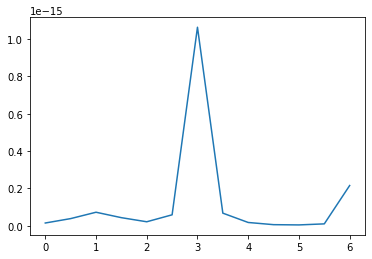

In [20]:
plt.plot(angles, np.array(errors))

In [157]:
%%time

errors = []
rapidities = np.arange(0, 10, 0.5)
tests = 10

for rapidity in rapidities:
    
    boost = get_boost(rapidity, 2).to("cuda")
    
    sub_errors = []
    for test in range(tests):
        
        model = SkipGeneralGNN(hparams).to("cuda")
        model.eval()
        with torch.no_grad():
            for batch in dataloader:
                output1 = model(batch.to("cuda"))

                X = batch.x.to("cuda")
                batch.x = torch.inner(X, boost)
                output2 = model(batch.to("cuda"))
                
                sub_errors.append(((output1 - output2).mean() / output1.mean()).abs().cpu())

    errors.append(sub_errors)

CPU times: user 12 s, sys: 14.8 s, total: 26.8 s
Wall time: 5min 16s


In [157]:
%%time

errors = []
rapidities = np.arange(0, 10, 0.5)
tests = 10

for rapidity in rapidities:
    
    boost = get_boost(rapidity, 2).to("cuda")
    
    sub_errors = []
    for test in range(tests):
        
        model = SkipGeneralGNN(hparams).to("cuda")
        model.eval()
        with torch.no_grad():
            for batch in dataloader:
                output1 = model(batch.to("cuda"))

                X = batch.x.to("cuda")
                batch.x = torch.inner(torch.inner(X, rot), boost)
                output2 = model(batch.to("cuda"))
                
                sub_errors.append(((output1 - output2).mean() / output1.mean()).abs().cpu())

    errors.append(sub_errors)

CPU times: user 12 s, sys: 14.8 s, total: 26.8 s
Wall time: 5min 16s


In [158]:
errors_mean, errors_std = np.array(errors).mean(axis=1), np.array(errors).std(axis=1)

In [163]:
errors_max = np.array(errors).max(axis=1)

In [162]:
errors

[[tensor(2.6370e-14, dtype=torch.float64),
  tensor(1.1299e-14, dtype=torch.float64),
  tensor(1.0729e-14, dtype=torch.float64),
  tensor(6.6424e-15, dtype=torch.float64),
  tensor(6.6607e-15, dtype=torch.float64),
  tensor(7.5856e-14, dtype=torch.float64),
  tensor(6.9367e-14, dtype=torch.float64),
  tensor(1.1377e-13, dtype=torch.float64),
  tensor(6.7003e-14, dtype=torch.float64),
  tensor(1.7111e-14, dtype=torch.float64)],
 [tensor(1.0062e-13, dtype=torch.float64),
  tensor(5.6990e-13, dtype=torch.float64),
  tensor(3.0069e-13, dtype=torch.float64),
  tensor(7.1121e-14, dtype=torch.float64),
  tensor(8.5616e-14, dtype=torch.float64),
  tensor(1.8682e-13, dtype=torch.float64),
  tensor(1.0860e-13, dtype=torch.float64),
  tensor(9.3152e-14, dtype=torch.float64),
  tensor(1.7261e-13, dtype=torch.float64),
  tensor(7.4111e-14, dtype=torch.float64)],
 [tensor(1.4921e-14, dtype=torch.float64),
  tensor(8.6944e-14, dtype=torch.float64),
  tensor(9.3308e-14, dtype=torch.float64),
  tensor(

In [161]:
errors_mean

array([4.04804584e-14, 1.76323682e-13, 1.74154575e-13, 1.47329475e-12,
       4.41831519e-12, 1.00773522e-11, 4.08911115e-11, 8.83503985e-11,
       1.01437605e-09, 2.99919115e-10, 1.84455246e-09, 1.60964924e-09,
       4.77198493e-09, 3.71039124e-07, 5.02201404e-08, 7.80031194e-07,
       1.37409041e-07, 3.35735159e-06, 4.86305363e-06, 1.56982936e-05])

In [159]:
errors_std

array([3.59596121e-14, 1.47469798e-13, 2.26842692e-13, 3.24038785e-12,
       7.25095646e-12, 2.22509614e-11, 3.17607923e-11, 1.05203335e-10,
       1.89390806e-09, 3.54507044e-10, 2.55674725e-09, 1.61376781e-09,
       2.98984477e-09, 9.42833098e-07, 6.81987296e-08, 1.96394829e-06,
       1.14166589e-07, 4.53358780e-06, 8.63955279e-06, 1.86447814e-05])

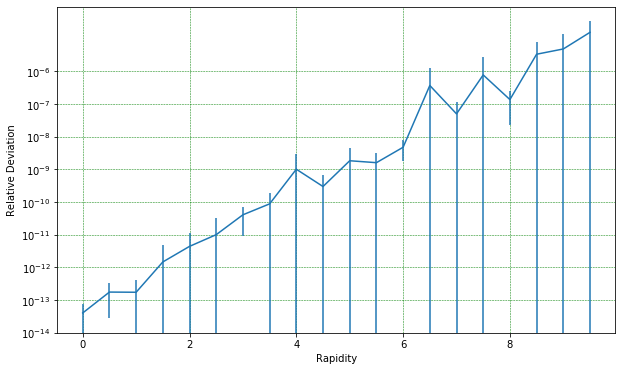

In [160]:
fig, ax = plt.subplots(1,1, figsize=(10,6))

plt.errorbar(rapidities, errors_mean, yerr=errors_std)
plt.yscale("log")
plt.grid(color = 'green', linestyle = '--', linewidth = 0.5)
plt.ylabel("Relative Deviation")
plt.xlabel("Rapidity")

ax.set_yticks([1e-14, 1e-13, 1e-12, 1e-11, 1e-10, 1e-9, 1e-8, 1e-7, 1e-6])

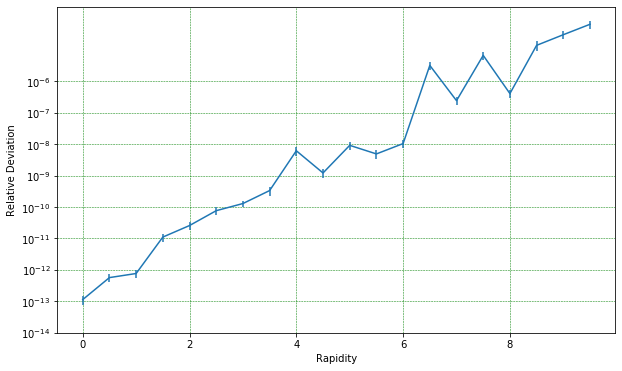

In [164]:
fig, ax = plt.subplots(1,1, figsize=(10,6))

plt.errorbar(rapidities, errors_max, yerr=errors_std)
plt.yscale("log")
plt.grid(color = 'green', linestyle = '--', linewidth = 0.5)
plt.ylabel("Relative Deviation")
plt.xlabel("Rapidity")

ax.set_yticks([1e-14, 1e-13, 1e-12, 1e-11, 1e-10, 1e-9, 1e-8, 1e-7, 1e-6])